#  Create a model for the EWK density as a function of 2 Wilson coefficients



---

## 1. Import libraries


In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import pyplot as plt, colors

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


---

## 2. Configure model

- Register input $c_{\rm HWB}$ and ${\tilde c}_{\rm W}$ values, and a function which locates their filenames


In [2]:
#  Inputs config

cHWB_vals  = [-4.0, -2.0, 0.0, 2.0, 4.0]
cWtil_vals = [-0.4, -0.2, 0.0, 0.2, 0.4]

def get_input_fname (cHWB, cWtil) :
    cHWB_str  = f"{cHWB :.1f}".replace("-","m").replace(".","p")
    cWtil_str = f"{cWtil:.1f}".replace("-","m").replace(".","p")
    if (cHWB == 0) and (cWtil == 0) :
        return "../Data/SM_EWK_500k_rivet_output.pickle"
    if (cHWB == 0) :
        return f"../Data/cWtil_{cWtil_str}_full_400k_rivet_output.pickle"
    return f"../Data/cHWB_{cHWB_str}_cWtil_{cWtil_str}_full_200k_rivet_output.dat"

#return "../Data/SM_EWK_rivet_output.pickle"
#return "../Data/SM_EWK_1M_rivet_output.pickle"

- Global config options

In [3]:
#  Model config

output_size_per_stage     = 25
max_epochs                = 1000
batch_size                = 100
epoch_increase_per_level  = 0
early_stopping_patience   = 5
early_stopping_min_delta  = 0
validation_split          = 0.3

white_linear_fraction_data  = [0.8, 0.9, 0.2, 0.2]      # [0.2, 0.8, 0.8, 0.7]  # 0.8
white_linear_fraction_gauss = 0.
whitening_num_points        = 200
whitening_func_form         = "step"
whitening_alpha, whitening_beta, whitening_gamma = 4, 3, 1

load_whitening_funcs = None             # ".whitening_funcs_2D.pickle"
save_whitening_funcs = None             # ".whitening_funcs_2D.pickle"

load_model_dir = None                       # ".EWK_density_model_2D"
save_model_dir = ".EWK_density_model_2D"    # ".EWK_density_model_2D"

learning_rate = 0.001                        # 0.01 for SGD or 0.001 otherwise
optimiser     = "adam"                       # SGD, Adam or AdaDelta


- Define domain for each observable
- Define which observables to discard
- Define how to order those that remain

In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "m_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["Dphi_j_j", "pT_ll", "m_jj", "Dy_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


---

## 3. Load input data

In [5]:
#  Load and format the data
#

data_tables = {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        input_fname = get_input_fname (cHWB, cWtil)
        print(f"Creating data table for cHWB={cHWB} and cWtil={cWtil}")
        print(f" -- events from file {input_fname}")
        data = DataTable(input_fname)
        print(f" -- Table created with {data.get_num_events()} events")
        for observable, limits in observable_limits.items() :
            print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
            data.filter(observable, limits[0], limits[1])
            print(f" -- {data.get_num_events()} events survived")
        for observable in remove_observables :
            print(f" -- removing observable {observable}")
            data.remove_column(observable)
        print(" -- ordering observables")
        data.reorder(*observables_order)
        data.print_summary()
        data_tables [(cHWB, cWtil)] = data
    

Creating data table for cHWB=-4.0 and cWtil=-0.4
 -- events from file ../Data/cHWB_m4p0_cWtil_m0p4_full_200k_rivet_output.dat
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 130332 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 130259 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 130259 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 128561 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 126644 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 126644 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 126644 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 126644 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 126614 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 126501 events survived
 -- filtering observable Dy_j_j bet

 -- 126217 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 126217 events survived
 -- removing observable N_jets
 -- removing observable m_ll
 -- removing observable rap_ll
 -- removing observable theta_ll
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | Dphi_j_j | <class 'float'> |
    | 1      | pT_ll    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dy_j_j   | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 0.7261         |
    +-

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 131742 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 131738 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 131738 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130007 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128133 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128133 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128133 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128133 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128110 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 128003 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 128003 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- 257601 events survived
 -- removing observable N_jets
 -- removing observable m_ll
 -- removing observable rap_ll
 -- removing observable theta_ll
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | Dphi_j_j | <class 'float'> |
    | 1      | pT_ll    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dy_j_j   | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 2.3163         |
    +-------------------------+

* Number of events       : 257601
* Cross section pe

 -- 264930 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 264832 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 264832 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 261459 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 257800 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 257799 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 257799 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 257799 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 257741 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 257542 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 257542 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 257542 events survived
 -- filtering observable N_jets between 2 and 5
 -- 257542 e

 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | Dphi_j_j | <class 'float'> |
    | 1      | pT_ll    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dy_j_j   | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.4441         |
    +-------------------------+

* Number of events       : 128984
* Cross section per event: 0.253354
* Total cross section    : 0.3658628898598382 +/- 0.0010198353809072616 pb
Creating data table for cHWB=2.0 and cWtil=0.2
 -- events from file ../Data/cHWB_2p0_cWtil_0p2_full_200k_rivet_output.dat
 -- Table created with 200000 events
 -- filtering observabl

 -- 132643 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130946 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129169 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129169 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129169 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129169 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 129145 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 129066 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 129066 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 129066 events survived
 -- filtering observable N_jets between 2 and 5
 -- 129066 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 129066 events survived
 -- removing observable N_jets
 -- removing observable m_ll
 -- removing ob

* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | Dphi_j_j | <class 'float'> |
    | 1      | pT_ll    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dy_j_j   | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.8044         |
    +-------------------------+

* Number of events       : 128839
* Cross section per event: 0.253931
* Total cross section    : 0.4582016269427781 +/- 0.0012779790920382052 pb


---

## 4. Project the data onto the latent space

- If whitening functions already saved to file, load these, otherwise evaluate them at the SM
- Whiten the data, and add it to a dictionary
- Also produce a dictionary of normalised weights which will be used to train
- Alternatively, create a second dictionary which weights points at the boundaries of the parameter grid more strongly (since points in the bulk of the space are also constrained by their neighbours, but no such neighbours exist at the boundaries)

In [6]:

#  Load whitening funcs if requested
#
whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points, white_linear_fraction_data[idx], white_linear_fraction_gauss] for idx, key in enumerate(data.keys)]

#  Evaluate whitening funcs if not loaded
#
if type(whitening_funcs) is type(None) :
    print("Evaluating whitening functions at the origin")
    data = data_tables [(0., 0.)]
    observables_origin, weights_origin = data.get_observables_and_weights()
    _, whitening_funcs = whiten_axes (observables_origin, data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=weights_origin, 
                                      func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)
     

Evaluating whitening functions at the origin


In [7]:

#  Whiten data
#   
observable_data, weight_data, white_data_to_fit = {}, {}, {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        data = data_tables [(cHWB, cWtil)]
        observables, weights = data.get_observables_and_weights()
        data.get_observables_and_weights()
        print(f"Whitening dataset for cHWB={cHWB}, cWtil={cWtil}")
        white_data_to_fit[(cHWB, cWtil)], whitening_funcs = whiten_axes (observables, data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=weights, 
                                                                         func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)
        observable_data [(cHWB, cWtil)], weight_data [(cHWB, cWtil)] = observables, weights

#  Save whitening funcs
#   
if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))

#  Normalise fit weights to unity
#   
weights_to_fit = {k:i/np.sum(i) for k,i in weight_data.items()}


Whitening dataset for cHWB=-4.0, cWtil=-0.4
Whitening dataset for cHWB=-4.0, cWtil=-0.2
Whitening dataset for cHWB=-4.0, cWtil=0.0
Whitening dataset for cHWB=-4.0, cWtil=0.2
Whitening dataset for cHWB=-4.0, cWtil=0.4
Whitening dataset for cHWB=-2.0, cWtil=-0.4
Whitening dataset for cHWB=-2.0, cWtil=-0.2
Whitening dataset for cHWB=-2.0, cWtil=0.0
Whitening dataset for cHWB=-2.0, cWtil=0.2
Whitening dataset for cHWB=-2.0, cWtil=0.4
Whitening dataset for cHWB=0.0, cWtil=-0.4
Whitening dataset for cHWB=0.0, cWtil=-0.2
Whitening dataset for cHWB=0.0, cWtil=0.0
Whitening dataset for cHWB=0.0, cWtil=0.2
Whitening dataset for cHWB=0.0, cWtil=0.4
Whitening dataset for cHWB=2.0, cWtil=-0.4
Whitening dataset for cHWB=2.0, cWtil=-0.2
Whitening dataset for cHWB=2.0, cWtil=0.0
Whitening dataset for cHWB=2.0, cWtil=0.2
Whitening dataset for cHWB=2.0, cWtil=0.4
Whitening dataset for cHWB=4.0, cWtil=-0.4
Whitening dataset for cHWB=4.0, cWtil=-0.2
Whitening dataset for cHWB=4.0, cWtil=0.0
Whitening data

In [8]:
#  Weight edges more highly to reduce interpolation bias

cHWB_sf, cWtil_sf = np.max(np.fabs(cHWB_vals)), np.max(np.fabs(cWtil_vals))
cHWB_sf, cWtil_sf = 1./cHWB_sf if (cHWB_sf>0) else 1., 1./cWtil_sf if (cWtil_sf>0) else 1.

weights_to_fit_2 = {k:(1+np.fabs(k[0])*cHWB_sf)*(1+np.fabs(k[1])*cWtil_sf)*i/np.sum(i) for k,i in weight_data.items()}

for key, weights in weights_to_fit_2.items() :
    print(f"Entry {key} weights normalised to {np.sum(weights):.3f}")


Entry (-4.0, -0.4) weights normalised to 4.000
Entry (-4.0, -0.2) weights normalised to 3.000
Entry (-4.0, 0.0) weights normalised to 2.000
Entry (-4.0, 0.2) weights normalised to 3.000
Entry (-4.0, 0.4) weights normalised to 4.000
Entry (-2.0, -0.4) weights normalised to 3.000
Entry (-2.0, -0.2) weights normalised to 2.250
Entry (-2.0, 0.0) weights normalised to 1.500
Entry (-2.0, 0.2) weights normalised to 2.250
Entry (-2.0, 0.4) weights normalised to 3.000
Entry (0.0, -0.4) weights normalised to 2.000
Entry (0.0, -0.2) weights normalised to 1.500
Entry (0.0, 0.0) weights normalised to 1.000
Entry (0.0, 0.2) weights normalised to 1.500
Entry (0.0, 0.4) weights normalised to 2.000
Entry (2.0, -0.4) weights normalised to 3.000
Entry (2.0, -0.2) weights normalised to 2.250
Entry (2.0, 0.0) weights normalised to 1.500
Entry (2.0, 0.2) weights normalised to 2.250
Entry (2.0, 0.4) weights normalised to 3.000
Entry (4.0, -0.4) weights normalised to 4.000
Entry (4.0, -0.2) weights normalised

---

# 5. Visualise the data at the SM, both on the data and latent spaces

Filter efficiency is 100.000%


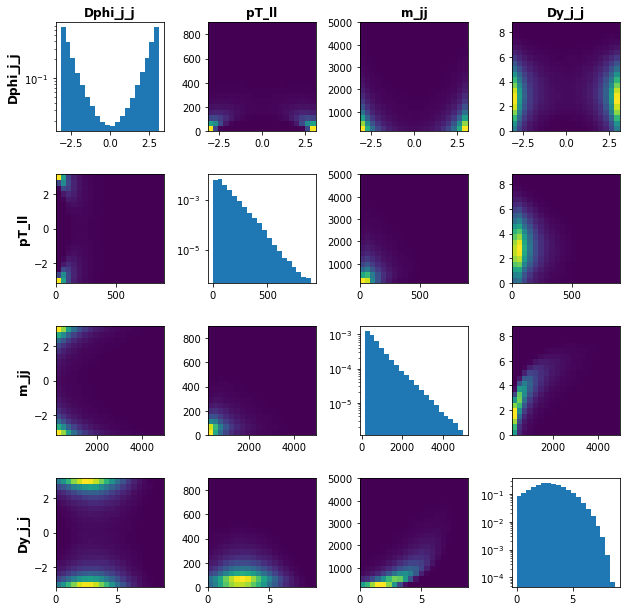

Filter efficiency is 100.000%


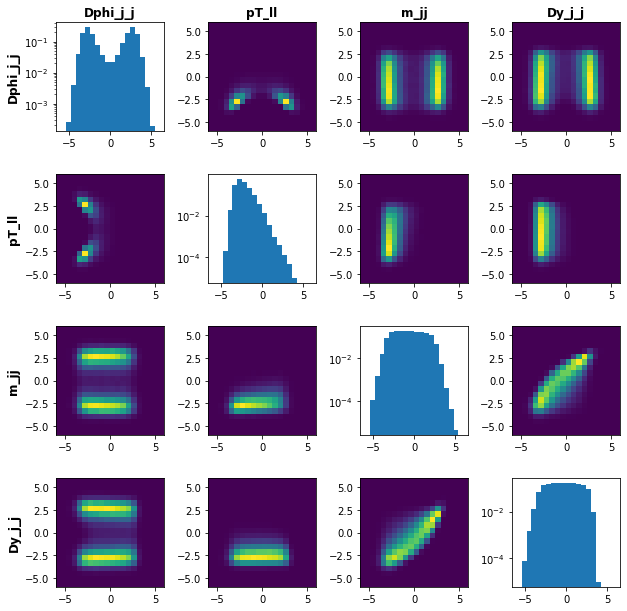

In [9]:

plot_data(observable_data  [(0,0)], weight_data   [(0,0)], keys=data.keys, bins=20, lims=True)
plot_data(white_data_to_fit[(0,0)], weights_to_fit[(0,0)], keys=data.keys, bins=20, lims=False)


In [10]:
import tensorflow as tf

fit_X = np.concatenate([np.full(fill_value=c, shape=(len(d),2)) for c,d in white_data_to_fit.items()])
fit_Y = np.concatenate([d for c,d in white_data_to_fit.items()])
fit_W = np.concatenate([d for c,d in weights_to_fit_2.items()])


def get_losses (model) :
    losses = model.split_evaluator.predict([fit_X, fit_Y])
    losses = np.multiply(fit_W[:, np.newaxis], losses)
    losses = np.sum(losses, axis=0)
    return losses


def reset_weights (model) :
    session = tf.compat.v1.keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, "kernel") :
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, "bias") :
            layer.bias.initializer.run(session=session)
            

In [11]:
#==================================
#===     LOAD / BUILD MODEL     ===
#==================================


#  Make sure eager execution is definitely off
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


#  Set the narrowness of the initial Gaussians (impacts postfit result)
density_model.Gauss_width_reduction_factor = 8.


#  Load model if requested, otherwise build and fit
#
if type(load_model_dir) != type(None) :
    model = DensityModel.from_dir(load_model_dir)
else :
    #
    #   Figure out the limits of the observables
    #
    range_limits = {}
    for idx in range(num_observables) :
        all_data   = np.concatenate([item[:,idx] for c,item in white_data_to_fit.items()])
        imin, imax = np.min(all_data), np.max(all_data)
        range_limits[idx] = [imin, imax] 
    #
    #   Create density model  
    #
    model = DensityModel(name            = "EWK_density_model", 
                         num_gaussians   = output_size_per_stage, 
                         num_conditions  = 2, 
                         num_observables = data.get_num_observables(), 
                         types           = data.types,
                         int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                         verbose         = True,
                         learning_rate   = learning_rate,
                         optimiser       = optimiser,
                         range_limits    = range_limits,
                         condition_limits = [[np.min(cHWB_vals ), np.max(cHWB_vals )],
                                             [np.min(cWtil_vals), np.max(cWtil_vals)]],
                         activation               = "leakyrelu",
                         A1                       = 10   ,
                         A2                       = 10   ,
                         B1                       = 10   ,
                         B2                       = 10   ,
                         C                        = 1    ,
                         D2                       = 2    ,
                         min_gauss_amplitude_frac = 0.   ,
                         gauss_mean_scale         = 1./8.,
                         gauss_frac_scale         = 1./8.,
                         gauss_sigma_scale        = 1./8.,
                         transform_min            = -2.  ,
                         transform_max            = 2.   )
    #
    #   Rebuild layers if they lead to INF/NaN initial loss for any datapoint
    #
    attempt, max_attempts = 0, 10
    while attempt < max_attempts :
        print("Evaluating losses")
        start_time = time.time()
        losses = get_losses(model)
        print(losses)
        print(f"Eval completed in {int(time.time() - start_time):.0f}s")
        indices_to_retry = [idx for idx, loss in zip(np.arange(num_observables), losses) if not np.isfinite(loss)]
        if len(indices_to_retry) > 0 :
            print(f"Rebuilding models for indices {', '.join([f'{idx}' for idx in indices_to_retry])}")
        else :
            attempt = max_attempts
        for idx in indices_to_retry :
            likelihood_model = model.likelihood_models[idx]
            reset_weights (likelihood_model.model)
                  

INFO       DensityModel.construct      Set model name              : EWK_density_model
INFO       DensityModel.construct      Set model num_gaussians     : 25
INFO       DensityModel.construct      Set model num_conditions    : 2
INFO       DensityModel.construct      Set model num_observables   : 4
INFO       DensityModel.construct      Set observable types        : [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer      : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.build          Building model segment: EWK_density_model_observable0 for obse

Model: "EWK_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, 2)            0           input_4[0][0]                    
__________________________________________________________________________________________________
lambda_20 (Lambda)              (None, 2)            0           input_5[0][0]                    
______________________________________________________________________

W0217 16:05:46.930381 4497421760 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Evaluating losses
[         -inf -406.19687986 -388.11071855          -inf          -inf]
Eval completed in 173s
Rebuilding models for indices 0, 3
Evaluating losses
[         -inf -406.19687986 -388.11071855          -inf          -inf]
Eval completed in 176s
Rebuilding models for indices 0, 3
Evaluating losses
[         -inf -406.19687986 -388.11071855          -inf          -inf]
Eval completed in 186s
Rebuilding models for indices 0, 3
Evaluating losses
[ -459.41692325  -406.19687986  -388.11071855  -421.46490292
 -1675.18942463]
Eval completed in 174s


In [12]:
#=================================
#===         FIT MODEL         ===
#=================================

improve_indices = [i for i in range(num_observables)]

for obs_idx in improve_indices :
    fit_start_time = time.time()
    num_epochs = max_epochs + obs_idx*epoch_increase_per_level
    model        .fit(white_data_to_fit, 
                      weights_to_fit_2,
                      observable                = obs_idx,
                      max_epochs_per_observable = num_epochs,
                      early_stopping_patience   = early_stopping_patience,
                      early_stopping_min_delta  = early_stopping_min_delta,
                      validation_split          = validation_split,
                      batch_size_per_observable = batch_size)
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 100
INFO       DensityModel.fit              -  Training setting: validation_split = 0.3
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 5
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 2738764 samples, validate on 1173756 samples
Epoch 1/1000
2738764/2738764 [==============================] - 105s 38us/sample - loss: 3.0151e-05 - val_loss: 2.9851e-05
Epoch 2/1000
2738764/2738764 [==============================] - 106s 39us/sample - loss: 2.9872e-05 - val_loss: 2.9841e-05
Epoch 3/1000
2738764/2738764 [==============================

2738764/2738764 [==============================] - 114s 42us/sample - loss: 1.0698e-05 - val_loss: 1.0511e-05
Epoch 4/1000
2738764/2738764 [==============================] - 114s 42us/sample - loss: 1.0544e-05 - val_loss: 1.0512e-05
Epoch 5/1000
2738764/2738764 [==============================] - 114s 42us/sample - loss: 1.0454e-05 - val_loss: 1.0246e-05
Epoch 6/1000
2738764/2738764 [==============================] - 113s 41us/sample - loss: 1.0387e-05 - val_loss: 1.0246e-05
Epoch 7/1000
2738764/2738764 [==============================] - 113s 41us/sample - loss: 1.0347e-05 - val_loss: 1.0479e-05
Epoch 8/1000
2738764/2738764 [==============================] - 113s 41us/sample - loss: 1.0321e-05 - val_loss: 1.0287e-05
Epoch 9/1000
2738764/2738764 [==============================] - 113s 41us/sample - loss: 1.0290e-05 - val_loss: 1.0932e-05
Epoch 10/1000
2738764/2738764 [==============================] - 114s 42us/sample - loss: 1.0269e-05 - val_loss: 1.0448e-05
Epoch 11/1000
2738764/273876

In [13]:
#=================================
#===       IMPROVE MODEL       ===
#=================================

improve_indices = [i for i in range(num_observables)]

for obs_idx in improve_indices :
    fit_start_time = time.time()
    num_epochs = max_epochs + obs_idx*epoch_increase_per_level
    model        .fit(white_data_to_fit, 
                      weights_to_fit_2,
                      observable                = obs_idx,
                      max_epochs_per_observable = 100,
                      early_stopping_patience   = 2,
                      early_stopping_min_delta  = 0,
                      validation_split          = -1,
                      batch_size_per_observable = 10000)
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 100
INFO       DensityModel.fit              -  Training setting: batch_size = 10000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 2
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 3912520 samples
Epoch 1/100
3912520/3912520 [==============================] - 31s 8us/sample - loss: 2.9843e-05
Epoch 2/100
3912520/3912520 [==============================] - 31s 8us/sample - loss: 2.9841e-05
Epoch 3/100
3912520/3912520 [==============================] - 32s 8us/sample - loss: 2.9841e-05
Epoch 4/100
3912520/3912520 [===============

3912520/3912520 [==============================] - 34s 9us/sample - loss: 2.9510e-05
Epoch 21/100
3912520/3912520 [==============================] - 34s 9us/sample - loss: 2.9510e-05
Epoch 22/100
3912520/3912520 [==============================] - 34s 9us/sample - loss: 2.9510e-05
Epoch 23/100
3912520/3912520 [==============================] - 34s 9us/sample - loss: 2.9510e-05
Epoch 24/100
3912520/3912520 [==============================] - 35s 9us/sample - loss: 2.9510e-05
Epoch 25/100
3912520/3912520 [==============================] - 35s 9us/sample - loss: 2.9510e-05
Epoch 26/100
3912520/3912520 [==============================] - 35s 9us/sample - loss: 2.9510e-05
Epoch 27/100
3912520/3912520 [==============================] - 34s 9us/sample - loss: 2.9510e-05
Epoch 28/100
3912520/3912520 [==============================] - 35s 9us/sample - loss: 2.9510e-05
Epoch 29/100
3912520/3912520 [==============================] - 35s 9us/sample - loss: 2.9510e-05
Epoch 30/100
3912520/3912520 [===

In [14]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    model.save_to_dir(save_model_dir)
    

In [15]:
#  Generate a large number of datapoints at 0.
#

n_gen = 50000

print(f"Generating {n_gen} fake datapoints for [cHWB, cWtil] = [0, 0]")
start = time.time()
fake_white_datapoints_SM = model.sample(n_gen, [0, 0])
end = time.time()
print(f"{n_gen} datapoints generated at (0, 0) in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for  (0, 0)")
start = time.time()
fake_datapoints_SM = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at (0, 0) in {int(end-start):.0f}s")


n_gen = 500000

print(f"Generating {n_gen} fake datapoints for [cHWB, cWtil] = [0, 0]")
start = time.time()
fake_white_datapoints_SM_big = model.sample(n_gen, [0, 0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for  (0, 0)")
start = time.time()
fake_datapoints_SM_big = unwhiten_axes(fake_white_datapoints_SM_big, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at (0, 0) in {int(end-start):.0f}s")


Generating 50000 fake datapoints for [cHWB, cWtil] = [0, 0]
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 50000 datapoints, observable index is 3
50000 datapoints generated at (0, 0) in 37s
Unwhitening fake datapoints for  (0, 0)
50000 datapoints unwhitened at (0, 0) in 1s
Generating 500000 fake datapoints for [cHWB, cWtil] = [0, 0]
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 3
500000 datapoints generated at cWtil=0 in 3

In [16]:
#  Get datapoint likelihoods at 0 hypothesis
#

fake_datapoint_SM_likelihood = model.evaluate([0, 0], fake_white_datapoints_SM)

fake_datapoint_weights = {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        start = time.time()
        fake_datapoint_weights [(cHWB, cWtil)] = model.evaluate([cHWB, cWtil], fake_white_datapoints_SM) / fake_datapoint_SM_likelihood
        end = time.time()
        print(f"{len(fake_white_datapoints_SM)} datapoints evaluated at {cHWB, cWtil} in {(end-start):.2f}s")


50000 datapoints evaluated at (-4.0, -0.4) in 2.26s
50000 datapoints evaluated at (-4.0, -0.2) in 2.38s
50000 datapoints evaluated at (-4.0, 0.0) in 2.25s
50000 datapoints evaluated at (-4.0, 0.2) in 2.30s
50000 datapoints evaluated at (-4.0, 0.4) in 2.25s
50000 datapoints evaluated at (-2.0, -0.4) in 2.26s
50000 datapoints evaluated at (-2.0, -0.2) in 2.25s
50000 datapoints evaluated at (-2.0, 0.0) in 2.25s
50000 datapoints evaluated at (-2.0, 0.2) in 2.25s
50000 datapoints evaluated at (-2.0, 0.4) in 2.25s
50000 datapoints evaluated at (0.0, -0.4) in 2.25s
50000 datapoints evaluated at (0.0, -0.2) in 2.25s
50000 datapoints evaluated at (0.0, 0.0) in 2.25s
50000 datapoints evaluated at (0.0, 0.2) in 2.25s
50000 datapoints evaluated at (0.0, 0.4) in 2.25s
50000 datapoints evaluated at (2.0, -0.4) in 2.25s
50000 datapoints evaluated at (2.0, -0.2) in 2.25s
50000 datapoints evaluated at (2.0, 0.0) in 2.25s
50000 datapoints evaluated at (2.0, 0.2) in 2.25s
50000 datapoints evaluated at (2

Filter efficiency is 100.000%


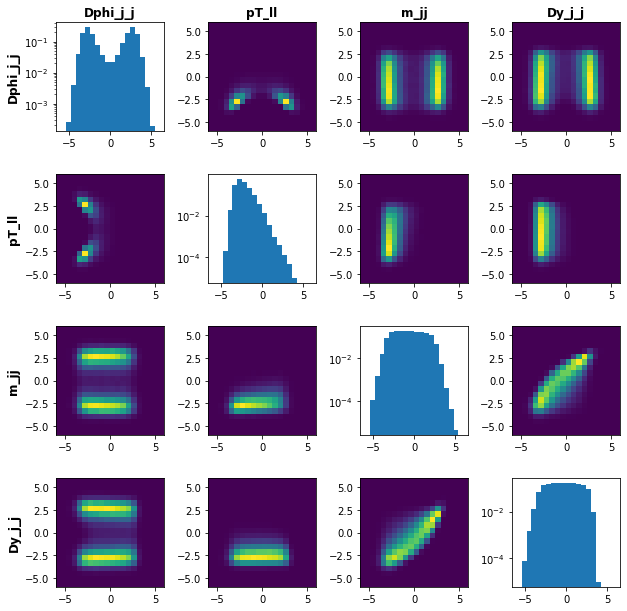

Filter efficiency is 100.000%


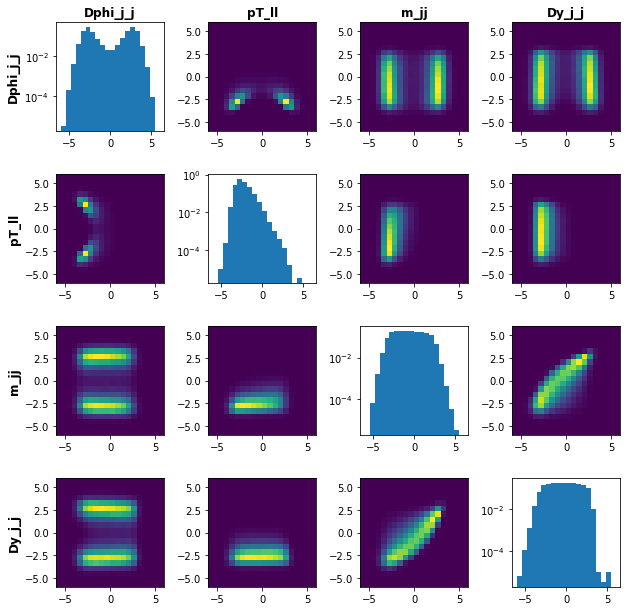

In [17]:
#  Plot original and generate data (total phase space)

plot_data(white_data_to_fit[(0, 0)]   , weights_to_fit[(0, 0)], keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints_SM_big, None                  , keys=data.keys, bins=20, lims=False)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value enco

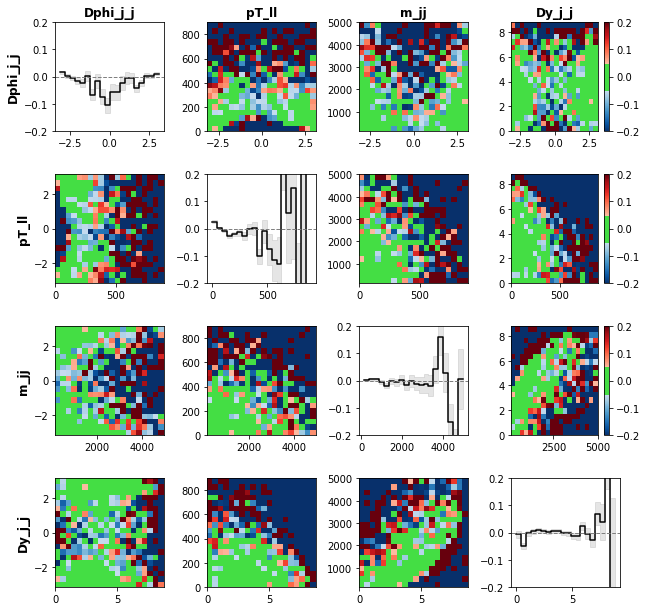

In [18]:
#  Plot ratio and pull between original and generated data (total phase space)

plot_ratio(observable_data[(0, 0)], fake_datapoints_SM_big, weights_to_fit[(0, 0)], None, keys=data.keys, bins=20)


In [19]:
#  Get a plot label for each observable
#

obs_labels = {}
obs_labels ["m_jj"    ] = r"$m_{jj}$  [TeV]"
obs_labels ["pT_ll"   ] = r"$p_{T}^{ll}$  [GeV]"
obs_labels ["Dphi_j_j"] = r"$\Delta\phi\left(j,j\right)$"
obs_labels ["Dy_j_j"  ] = r"$\Delta y\left(j,j\right)$"

def get_obs_label (obs) :
    if obs in obs_labels :
        return obs_labels[obs]
    return obs


#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k", label=label)
    if ebar :ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.3, color="grey")
    ax.set_xlim([bins[0], bins[-1]])
    
    ax.axhline(0    , linestyle="-" , c="grey", linewidth=2  )
    for h in [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4] :
        ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)


#  Plot the datapoints provided
#
def plot_observable_on_axis2 (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, linecolor="k", fillcolor="grey", normed=True, ebar=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color=linecolor, label=label, linewidth=2)
    if ebar : ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.4, color=fillcolor)
        
    return data_x, data_z, data_ez
        

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value e

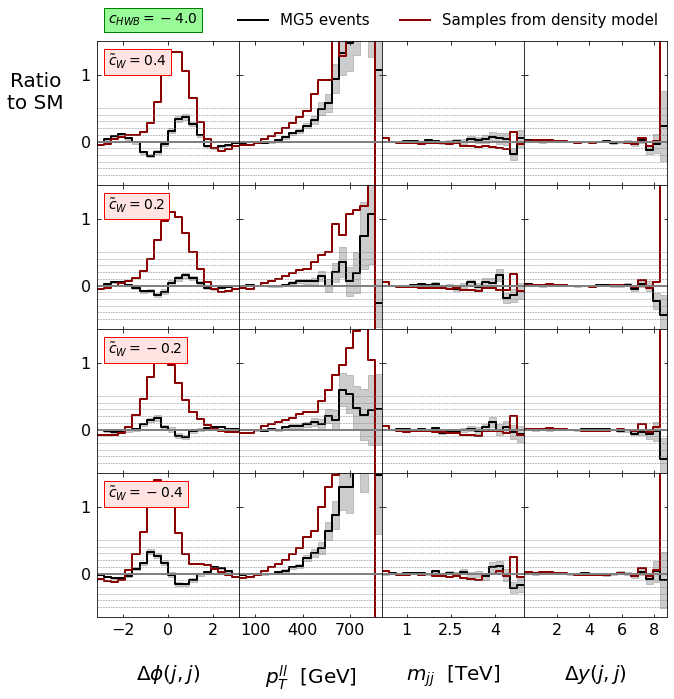

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value e

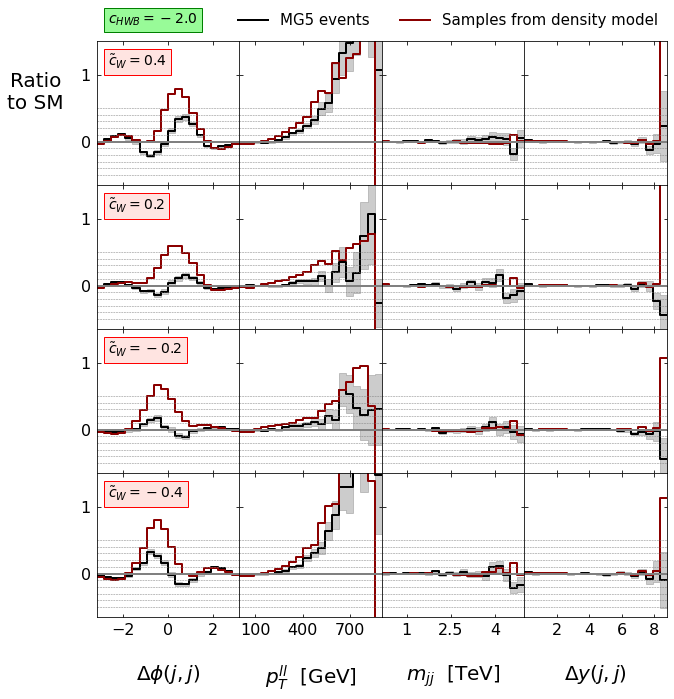

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value e

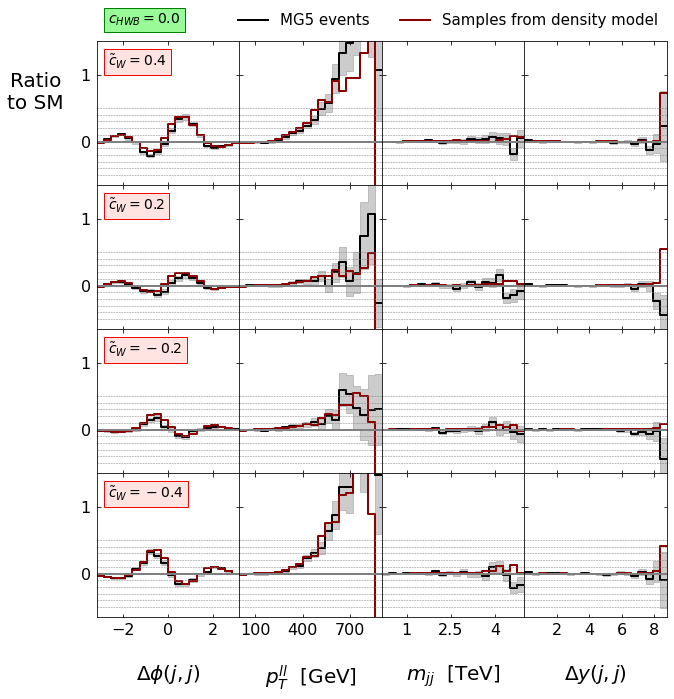

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value e

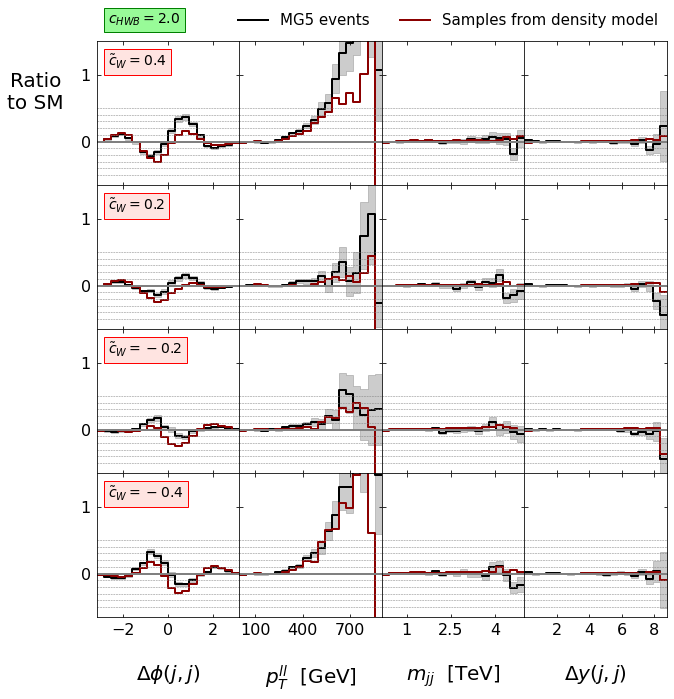

/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:143: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1  = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:144: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2  = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:145: RuntimeWarning: invalid value e

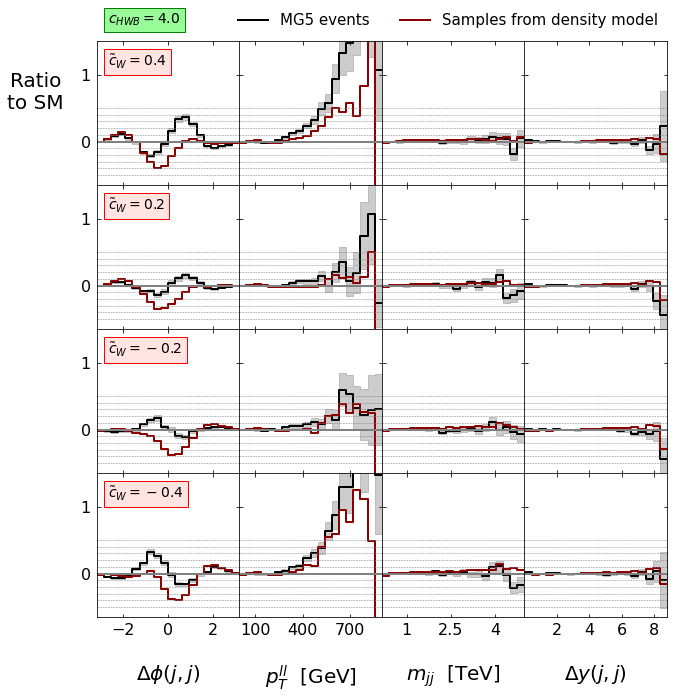

In [26]:
columns = [[(-4., 0.4), (-4., 0.2), (-4., -0.2), (-4., -0.4)], 
           [(-2., 0.4), (-2., 0.2), (-2., -0.2), (-2., -0.4)], 
           [(0. , 0.4), (0. , 0.2), (0. , -0.2), (0. , -0.4)], 
           [(2. , 0.4), (2. , 0.2), (2. , -0.2), (2. , -0.4)], 
           [(4. , 0.4), (4. , 0.2), (4. , -0.2), (4. , -0.4)]]

#columns = [[(0. , 0.4), (0. , 0.2), (0. , -0.2), (0. , -0.4)]]

for col_idx, column in enumerate(columns) :
    num_c_in_col  = len(column)
    height, width = 2+2*num_c_in_col, 2*num_observables
    fig           = plt.figure(figsize=(width, height))
    first_axis    = None
    for c_idx, (cHWB, cWtil) in enumerate(column) :
        pad_xlo, pad_xwidth = 0.01, 0.99
        pad_ylo, pad_yheight = 1.-(1+c_idx)*2./height, 2./height
        for obs_idx, obs in enumerate(observables_order) :
            ax   = fig.add_axes([pad_xlo+obs_idx*pad_xwidth/num_observables, pad_ylo, pad_xwidth/num_observables, pad_yheight])
            data = data_tables [(0, cWtil)]
            observables, weights = data.get_observables_and_weights()
            n_pts = len(fake_datapoints_SM)
            data_x, _, _ = plot_observable_on_axis2 (ax, obs, observables       , observable_data[(0, 0)], weights                              , weights_to_fit        [(0,0)], keys=data.keys, bins=20, normed=True, ebar=True, label="MG5 events")
            data_x, _, _ = plot_observable_on_axis2 (ax, obs, fake_datapoints_SM, fake_datapoints_SM     , fake_datapoint_weights[(cHWB, cWtil)].reshape(n_pts), fake_datapoint_weights[(0,0)].reshape(n_pts), keys=data.keys, bins=20, normed=True, label="Samples from density model", linecolor="darkred", fillcolor="red")
            ax.set_xlim([data_x[0], data_x[-1]])
            ax.axhline(0, linestyle="-" , c="grey", linewidth=2  )
            for h in [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5] :
                ax.axhline(h, linestyle="--", c="grey", linewidth=0.5)
            if obs_idx == 0 :
                ax.text(0.08, 0.92, r"${\tilde c}_W="+f"{cWtil:.1f}$", fontsize=14, transform=ax.transAxes, ha="left", va="top"   , bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
                if c_idx == 0 :
                    ax.set_ylabel("Ratio\nto SM", fontsize=20, labelpad=45, rotation=0)
            else :
                ax.get_yaxis().set_ticklabels([])
            ax.set_ylim([-0.65, 1.5])
            ax.tick_params(which="both", right=True, top=True, labelsize=16, pad=6, direction="in")
            if type(first_axis) == type(None) : first_axis = ax
            if obs_idx == 0 : ax.set_xticks([-2, 0, 2])
            if obs_idx == 1 : ax.set_xticks([100, 400, 700])
            if obs_idx == 2 : 
                ax.set_xticks([1000, 2500, 4000])
                ax.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
            if obs_idx == 3 : ax.set_xticks([2, 4, 6, 8])
            if c_idx == num_c_in_col-1 :
                ax.set_xlabel(get_obs_label(obs), fontsize=20, labelpad=25)
            else :
                ax.get_xaxis().set_ticklabels([])
    first_axis.legend(loc=(0.95, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=15)
    first_axis.text(0.08, 1.09, r"$c_{HWB}="     +f"{cHWB:.1f}$" , fontsize=14, transform=first_axis.transAxes, ha="left", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0))
    #plt.savefig(f"figures/whitening_method/EWK_events_2D_col{col_idx}.pdf", bbox_inches="tight")
    plt.show()


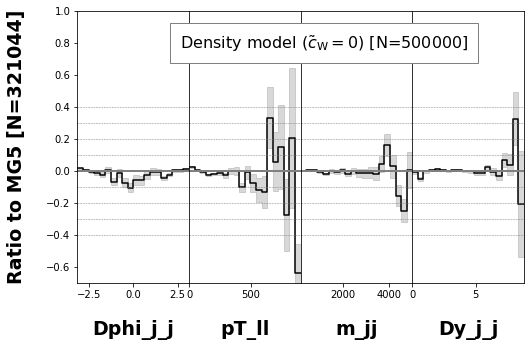

In [21]:

fig = plt.figure(figsize=(2*num_observables, 5))
for idx, obs in enumerate(observables_order) :
    ax = fig.add_subplot(1, num_observables, 1+idx)
    datapoints_true, weights_true = data_tables [(0,0)].get_observables_and_weights()
    plot_observable_on_axis (ax, obs, fake_datapoints_SM_big, datapoints_true, None, weights_true, keys=data.keys, bins=20, normed=True, ebar=True)
    ax.set_xlabel(obs, weight="bold", fontsize=19, labelpad=20)
    if idx == 0 :
        ax.set_ylabel(f"Ratio to MG5 [N={datapoints_true.shape[0]}]", fontsize=19, labelpad=20, weight="bold")
    else :
        ax.set_yticks([])
    if idx == num_observables-1 :
        ax.text(0.5, 0.92, r"${\rm Density~model}~({\tilde c}_{\rm W}="+f"0)$ [N={fake_datapoints_SM_big.shape[0]}]", fontsize=16, transform=ax.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='grey', pad=10.0))
    ax.set_ylim([-0.7, 1.])
plt.subplots_adjust(wspace=0)
#plt.savefig(f"figures/EWK_ratio_at_SM.pdf", bbox_inches="tight")
plt.show()


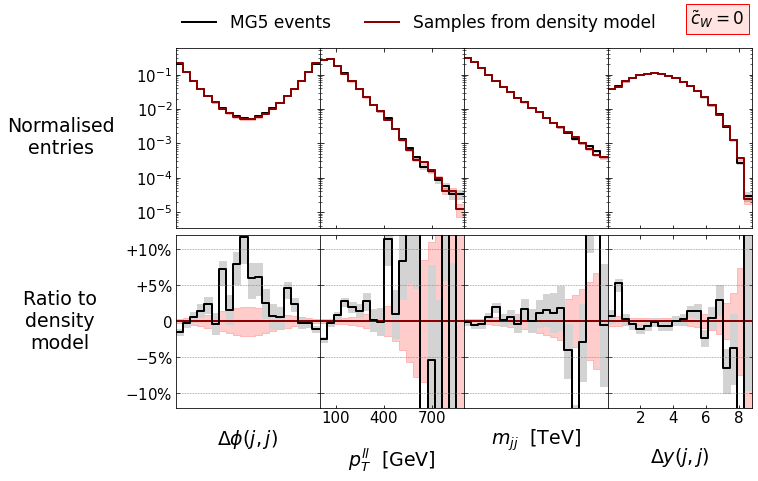

In [22]:

#  Data space distribution & ratio (c=0)
def histo_to_line (bins, values, errors) :
    X, Z, EZ = [], [], []
    for zp in values :
        Z .append(zp)
        Z .append(zp)
    for ezp in errors :
        EZ.append(ezp)
        EZ.append(ezp)
    for i in range(len(bins)-1) :
        X .append(bins[i])
        X .append(bins[i+1])
    return np.array(X), np.array(Z), np.array(EZ)


fig = plt.figure(figsize=(8, 5))

axes1, axes2 = [], []
ylos , yhis  = [], []

for obs_idx, observable in enumerate(observables_order) :
    
    #  Get axis x coordinates
    xlo    = obs_idx / num_observables
    xwidth = 1.      / num_observables
    
    #  ============
    #     AXIS 1
    #  ============

    ax1 = fig.add_axes([xlo, 0.50, xwidth, 0.5])
    
    datapoints_true, weights_true = data_tables [(0,0)].get_observables_and_weights()
    
    obs_lims   = observable_limits[observable]
    num_bins   = 20
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], num_bins+1)
        
    hvals1, _ = np.histogram(datapoints_true       [:,obs_idx], bins=bins, weights=weights_true             )
    herrs1, _ = np.histogram(datapoints_true       [:,obs_idx], bins=bins, weights=weights_true*weights_true)
    herrs1    = np.sqrt(herrs1)
    hvals1, herrs1 = hvals1/np.sum(weights_true), herrs1/np.sum(weights_true)
    #hvals1, herrs1 = hvals1/np.max(hvals1), herrs1/np.max(hvals1)
    hvals2, _ = np.histogram(fake_datapoints_SM_big[:,obs_idx], bins=bins)
    herrs2    = np.sqrt(hvals2)
    hvals2, herrs2 = hvals2/len(fake_datapoints_SM_big), herrs2/len(fake_datapoints_SM_big)
    #hvals2, herrs2 = hvals2/np.max(hvals2), herrs2/np.max(hvals2)
    
    plot_x, plot_y1, plot_ey1 = histo_to_line(bins, hvals1, herrs1)
    _     , plot_y2, plot_ey2 = histo_to_line(bins, hvals2, herrs2)
    
    ax1.plot(plot_x, plot_y1, "-", color="k"      , linewidth=2, label="MG5 events")
    ax1.fill_between(plot_x, plot_y1-plot_ey1, plot_y1+plot_ey1, color="lightgrey", alpha=1)
    ax1.plot(plot_x, plot_y2, "-", color="darkred", linewidth=2, label="Samples from density model")
    ax1.fill_between(plot_x, plot_y2-plot_ey2, plot_y2+plot_ey2, color="red", alpha=0.2)
    ax1.set_yscale("log")
    
    # Save y values range
    ylo, yhi = np.min([plot_y1-plot_ey1, plot_y2-plot_ey2]), np.max([plot_y1+plot_ey1, plot_y2+plot_ey2])
    ylos.append(ylo)
    yhis.append(yhi)
        
    
    #  ============
    #     AXIS 2
    #  ============

    ax2 = fig.add_axes([xlo, 0, xwidth, 0.48])
    
    ax2.axhline(0, c="darkred", linewidth=2)
    ax2.fill_between(plot_x, -plot_ey2/plot_y2, plot_ey2/plot_y2, color="red", alpha=0.2)
    ax2.plot(plot_x, (plot_y1-plot_y2)/plot_y2, c="k", linewidth=2)
    ax2.fill_between(plot_x, (plot_y1-plot_ey1-plot_y2)/plot_y1, (plot_y1+plot_ey1-plot_y2)/plot_y1, color="lightgrey", alpha=1)
    ax2.set_ylim([-0.12, 0.12])
    
    for h in [-0.1, -0.05, 0.05, 0.1] :
        ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)
    
    #  Set y axis tick labels    
    if obs_idx > 0 :
        ax1.get_yaxis().set_ticklabels([])
        ax2.get_yaxis().set_ticklabels([])
        
    #  Set x axis tick labels
    ax1.get_xaxis().set_ticklabels([])
    if obs_idx == 0 : 
        ax1.set_xticks([1000, 2500, 4000])
        ax2.set_xticks([1000, 2500, 4000])
        ax2.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
    if obs_idx == 1 : 
        ax1.set_xticks([100, 400, 700])
        ax2.set_xticks([100, 400, 700])
    if obs_idx == 2 : 
        ax1.set_xticks([-2, 0, 2])
        ax2.set_xticks([-2, 0, 2])
    if obs_idx == 3 : 
        ax1.set_xticks([2, 4, 6, 8])
        ax2.set_xticks([2, 4, 6, 8])
        
    #  Set x axis labels
    ax2.set_xlabel(get_obs_label(observable), fontsize=19, labelpad=20)
        
    #  Set y axis labels
    if obs_idx == 0 : 
        ax1.set_ylabel("Normalised\nentries", fontsize=19, labelpad=75, rotation=0, va="center")
        ax2.set_ylabel("Ratio to\ndensity\nmodel", fontsize=19, labelpad=65, rotation=0, va="center")
        ax1.legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=17)
      
    #  Draw cWtil label
    if obs_idx == (num_observables-1) : 
        ax1.text(0.95, 1.1, r"${\tilde c}_W=0$", fontsize=17, transform=ax1.transAxes, ha="right", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
    
    #  Set x limits
    ax1.set_xlim([bins[0], bins[-1]])
    ax2.set_xlim([bins[0], bins[-1]])
    
    #  Set tick params
    ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    
    #  Save axes
    axes1.append(ax1)
    axes2.append(ax2)

        
#  Set consistent axis y lims
for ax in axes1 :
    ax.set_ylim([np.min(ylos)/2., 2.*np.max(yhis)])

'''axes1[0].set_yticks     ([1, 0.1, 0.01, 0.001])
axes1[0].set_yticklabels([r"$100\%$", r"$10\%$", r"$1\%$", r"$0.1\%$"])'''

axes2[0].set_yticks     ([-0.1, -0.05, 0, 0.05, 0.1])
axes2[0].set_yticklabels([r"$-10\%$", r"$-5\%$", r"$0$", r"$+5\%$", r"$+10\%$"])
 
#plt.savefig(f"figures/whitening_method/1D_distributions_density_model.pdf", bbox_inches="tight")
plt.show()


In [23]:
def plot_data_adv (datapoints, weights=None, label="", savefig="") :
    
    #  If no weights provided then assume uniform
    if type(weights) == type(None) :
        weights = np.ones(shape=(datapoints.shape[0],))
    
    #  Get histo bins
    get_bins = {}
    for obs_idx_x, obs_x in enumerate(observables_order) :
        obs_lims_x = observable_limits[obs_x]
        num_bins_x = 20
        if obs_x in int_observables : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0]-0.5, obs_lims_x[1]+0.5, 1+(obs_lims_x[1]-obs_lims_x[0]))
        else                        : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0], obs_lims_x[1], num_bins_x+1)

    #  First figure out our colour axis limits
    #     whilst we're at it, save the list of indices to plot (to make sure all loops are over consistent sets)
    vmin = 1e30
    observables_for_x, observables_for_y = [], []
    for obs_idx_x, obs_x in enumerate(observables_order) :
        #  Don't plot observable -1 on x axis
        if obs_idx_x == num_observables-1 : continue
        observables_for_x.append(obs_idx_x)
        for obs_idx_y, obs_y in enumerate(observables_order) :
            #  Don't plot observable 0 or above diagonal on y axis
            if obs_idx_y == 0         : continue
            if obs_idx_y <= obs_idx_x : continue
            observables_for_y.append(obs_idx_y)
            #  Get histo limits
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            vals, _, _ = np.histogram2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights, bins=(bins_x, bins_y))
            vals = vals.flatten()
            vals_min, vals_max = np.nanmin([v for v in vals if v > 0]), np.nanmax([v for v in vals if v > 0])
            vmin = np.nanmin([vmin, vals_min/vals_max])

    #  Make plot
    fig = plt.figure(figsize=(8, 5))
    vmin = 1e-5

    for obs_idx_x, obs_x in enumerate(observables_order) :

        #  Check whether we want to plot observable x
        if obs_idx_x not in observables_for_x : continue

        #  Get axis x coordinates
        xlo    = obs_idx_x / (num_observables-1)
        xwidth = 1.        / (num_observables-1)

        for obs_idx_y, obs_y in enumerate(observables_order) :

            #  Check whether we want to plot observable y
            if obs_idx_y not in observables_for_y : continue
            if obs_idx_y <= obs_idx_x : continue

            #  Get axis y coordinates
            ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)
            yheight = 1.                            / (num_observables-1)

            #  Create axis
            ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])

            #  Decide whether to draw axis labels
            if obs_idx_x != 0 : ax.get_yaxis().set_ticklabels([])
            else : 
                ax.set_ylabel(get_obs_label(obs_y), fontsize=19, labelpad=20)
            if obs_idx_y != num_observables-1 : ax.get_xaxis().set_ticklabels([])
            else : 
                ax.set_xlabel(get_obs_label(obs_x), fontsize=19, labelpad=20)
            
            if (obs_idx_x == 0) and (obs_idx_y == num_observables-1) : ax.get_xaxis().set_ticklabels(["1" , "2.5", "4" ])
            if (obs_idx_x == 0) and (obs_idx_y == 0) : ax.get_yaxis().set_ticklabels(["1" , "2.5", "4" ])
            if obs_idx_x == 0 : ax.set_xticks([1000, 2500, 4000])
            if obs_idx_x == 1 : ax.set_xticks([100, 400, 700])
            if obs_idx_x == 2 : ax.set_xticks([-2, 0, 2])
            if obs_idx_x == 3 : ax.set_xticks([2, 4, 6, 8])
        
            #  Format tick params
            ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

            #  Draw histogram
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            _, _, _, patches = ax.hist2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights/vals_max, bins=(bins_x, bins_y),
                                      vmin=vmin, vmax=1, norm=colors.LogNorm())
            
            if (obs_idx_x==0) and (obs_idx_y==1) and len(label) > 0 :
                ax.text(0, 1.2, r"${\tilde c}_W=0$", fontsize=21, transform=ax.transAxes, ha="left", va="bottom", bbox=dict(facecolor='mistyrose', edgecolor='red', pad=4.0))
                ax.text(0.5, 1.2, label, weight="bold", ha="left", va="bottom", transform=ax.transAxes, fontsize=21)
                

    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(patches, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])
    cbar   .set_label(r"$\frac{p(x)}{{\rm max}~p(x)}$", fontsize=25, labelpad=50, rotation=0, va="center")

    if len(savefig) > 0 :
        plt.savefig(savefig, bbox_inches="tight")
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


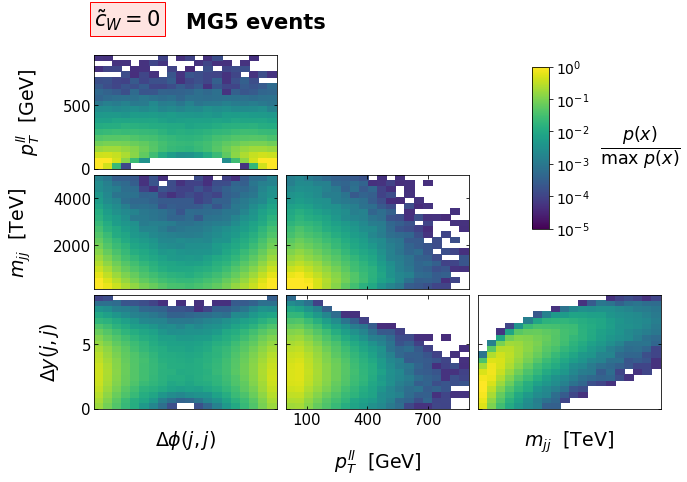

In [24]:

#  Plot MG5 events
datapoints_true, weights_true = data_tables[(0,0)].get_observables_and_weights()
plot_data_adv(datapoints_true, weights_true, label="MG5 events")


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


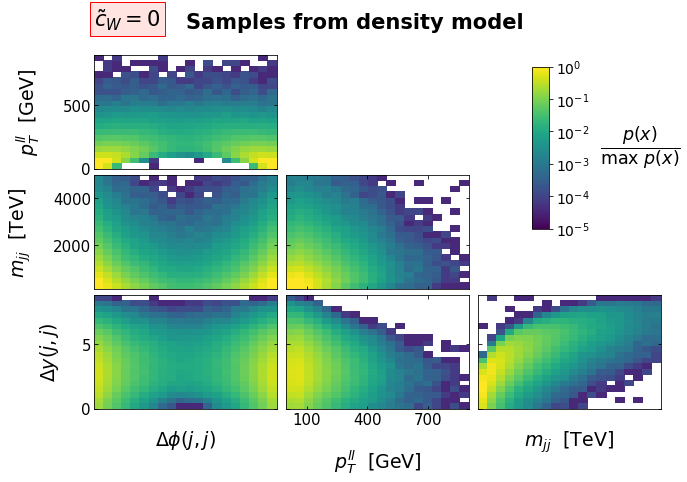

In [25]:

#  Plot generated events
plot_data_adv(fake_datapoints_SM_big, label="Samples from density model")
